In this notebook, we are going to fine-tune `LayoutLMv2ForTokenClassification` on the [CORD](https://github.com/clovaai/cord) dataset. The goal for the model is to label words appearing in scanned documents (namely, receipts) appropriately. This task is treated as a NER problem (sequence labeling). However, compared to BERT, LayoutLMv2 also incorporates visual and layout information about the tokens when encoding them into vectors. This makes the LayoutLMv2 model very powerful for document understanding tasks.

LayoutLMv2 is itself an upgrade of LayoutLM. The main novelty of LayoutLMv2 is that it also pre-trains visual embeddings, whereas the original LayoutLM only adds visual embeddings during fine-tuning.

* Paper: https://arxiv.org/abs/2012.14740
* Original repo: https://github.com/microsoft/unilm/tree/master/layoutlmv2

NOTES: 

* you first need to prepare the CORD dataset for LayoutLMv2. For that, check out the notebook "Prepare CORD for LayoutLMv2".
* this notebook is heavily inspired by [this Github repository](https://github.com/omarsou/layoutlm_CORD), which fine-tunes both BERT and LayoutLM (v1) on the CORD dataset.



## Install dependencies

First, we install the required libraries:
* Transformers (for the LayoutLMv2 model)
* Datasets (for data preprocessing)
* Seqeval (for metrics)
* Detectron2 (which LayoutLMv2 requires for its visual backbone).



In [1]:
!rm -r transformers
!git clone -b modeling_layoutlmv2_v2 https://github.com/NielsRogge/transformers.git
!cd tranformers
!pip install -q ./transformers 

Cloning into 'transformers'...
remote: Enumerating objects: 128340, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 128340 (delta 38), reused 53 (delta 26), pack-reused 128255
Receiving objects: 100% (128340/128340), 106.59 MiB | 19.52 MiB/s, done.
Resolving deltas: 100% (94181/94181), done.
/bin/bash: line 0: cd: tranformers: No such file or directory
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [2]:
!pip install -q datasets seqeval

In [3]:
!pip install pyyaml==5.1
# workaround: install old version of pytorch since detectron2 hasn't released packages for pytorch 1.9 (issue: https://github.com/facebookresearch/detectron2/issues/3158)
!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# install detectron2 that matches pytorch 1.8
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install -q detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [4]:
!pip install gradio
!pip install pytesseract
!pip install tesseract
!pip install tesseract-ocr
import pytesseract

# Define Paths
poppler_path = r'C:\Program Files\poppler-0.68.0\bin'
# pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'

!sudo apt install tesseract-ocr
!pip install pytesseract
# !sudo apt install tesseract-ocr
!pip install pytesseract

import pytesseract
import shutil
import os
import random
try:
 from PIL import Image
except ImportError:
 import Image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tesseract-ocr-0.0.1.tar.gz (33 kB)
  ERROR: Failed building wheel for tesseract-ocr
  Running setup.py clean for tesseract-ocr
Failed to build tesseract-ocr
    Running setup.py install for tesseract-ocr ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-t7pw_f4n/tesseract-ocr_cf40bcdb6d5342848827e260867b7894/setup.py'"'"'; __file__='"'"'/tmp/pip-install-t7pw_f4n/tesseract-ocr_cf40bcdb6d5342848827e260867b7894/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) 

In [5]:
!pip install Pillow==9.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Prepare the data

First, let's read in the annotations which we prepared in the other notebook. These contain the word-level annotations (words, labels, normalized bounding boxes).

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import pandas as pd

train = pd.read_pickle('/content/drive/MyDrive/EuroCoorp/CORDTest/layoutLMV2 -CORD/pickle/train.pkl')
val = pd.read_pickle('/content/drive/MyDrive/EuroCoorp/CORDTest/layoutLMV2 -CORD/pickle/val.pkl')
test = pd.read_pickle('/content/drive/MyDrive/EuroCoorp/CORDTest/layoutLMV2 -CORD/pickle/test.pkl')

In [8]:
train

[[['&“~ EUROCORPORATION CONSULENZA E GESTIONE RIFLUTL',
   'PER AUTISTA',
   'PER UFFICIO',
   'PRODUTTORE',
   'D&D Costruzioni SRL',
   'CLIENTE',
   'D&D Costruzioni SRL',
   'Operatore',
   'Mario Nobile - Mob. 3381558401',
   'CF Produttore',
   '06725110487',
   'Email Cliente',
   'info@ddcostruzioni.net',
   'Email Produttore',
   'info@ddcostruzioni.net',
   'ORARI',
   'UnitLoc.',
   'PORTA ROMANA - VIA METASTASIO 48 50124 (FI)',
   'Referente',
   'FABRIZIO PIPOLO',
   'Telefono',
   '3357566640',
   'Data Richiesta',
   '23/02/2022',
   'orario richiesta',
   '08:00',
   'Mattina',
   'Dalle 08:00 Alle 12:00',
   'Pomeriggio',
   'Dalle Alle',
   'VEICOLO RICHIESTO',
   'Tipologia rifiuto',
   'CER',
   '170904.1',
   'PER LA LOGISTICA',
   'SCHEDA FATTA DA MATILDE CHIAMARE PER COMUNICARE ORARIO Florec 3200436592 PORTARE A CAMBIO N.5 CASSE VENERDì MATTINA 25.02.2022https://www.google.com/maps/@43.7602578,11.2378078,3a,75y,244.78h,76.14t/data=!3m7!1e1!3m5! 1sd6ERXwcpkiHcDdpt

Let's define a list of all unique labels. For that, let's first count the number of occurrences for each label:

In [9]:
from collections import Counter

all_labels = [item for sublist in train[1] for item in sublist] + [item for sublist in val[1] for item in sublist] + [item for sublist in test[1] for item in sublist]
Counter(all_labels)

Counter({'answer': 95, 'header': 11, 'other': 41, 'question': 93})

As we can see, there are some labels that contain very few examples. Let's replace them by the "neutral" label "O" (which stands for "Outside").

In [10]:
replacing_labels = {'referente': 'O'}

In [11]:
def replace_elem(elem):
  try:
    return replacing_labels[elem]
  except KeyError:
    return elem
def replace_list(ls):
  return [replace_elem(elem) for elem in ls]
train[1] = [replace_list(ls) for ls in train[1]]
val[1] = [replace_list(ls) for ls in val[1]]
test[1] = [replace_list(ls) for ls in test[1]]

In [12]:
all_labels = [item for sublist in train[1] for item in sublist] + [item for sublist in val[1] for item in sublist] + [item for sublist in test[1] for item in sublist]
Counter(all_labels)

Counter({'answer': 95, 'header': 11, 'other': 41, 'question': 93})

Now we have to save all the unique labels in a list.

In [13]:
labels = list(set(all_labels))
print(labels)

['question', 'header', 'other', 'answer']


In [14]:
label2id = {label: idx for idx, label in enumerate(labels)}
id2label = {idx: label for idx, label in enumerate(labels)}
print(label2id)
print(id2label)

{'question': 0, 'header': 1, 'other': 2, 'answer': 3}
{0: 'question', 1: 'header', 2: 'other', 3: 'answer'}


In [15]:
from os import listdir
from torch.utils.data import Dataset
import torch
from PIL import Image

class CORDDataset(Dataset):
    """CORD dataset."""

    def __init__(self, annotations, image_dir, processor=None, max_length=512):
        """
        Args:
            annotations (List[List]): List of lists containing the word-level annotations (words, labels, boxes).
            image_dir (string): Directory with all the document images.
            processor (LayoutLMv2Processor): Processor to prepare the text + image.
        """
        self.words, self.labels, self.boxes = annotations
        self.image_dir = image_dir
        self.image_file_names = [f for f in listdir(image_dir)]
        self.processor = processor

    def __len__(self):
        return len(self.image_file_names)

    def __getitem__(self, idx):
        # first, take an image
        item = self.image_file_names[idx]
        image = Image.open(self.image_dir + item).convert("RGB")

        # get word-level annotations 
        words = self.words[idx]
        boxes = self.boxes[idx]
        word_labels = self.labels[idx]

        assert len(words) == len(boxes) == len(word_labels)
        
        word_labels = [label2id[label] for label in word_labels]
        # use processor to prepare everything
        encoded_inputs = self.processor(image, words, boxes=boxes, word_labels=word_labels, 
                                        padding="max_length", truncation=True, 
                                        return_tensors="pt")
        
        # remove batch dimension
        for k,v in encoded_inputs.items():
          encoded_inputs[k] = v.squeeze()

        assert encoded_inputs.input_ids.shape == torch.Size([512])
        assert encoded_inputs.attention_mask.shape == torch.Size([512])
        assert encoded_inputs.token_type_ids.shape == torch.Size([512])
        assert encoded_inputs.bbox.shape == torch.Size([512, 4])
        assert encoded_inputs.image.shape == torch.Size([3, 224, 224])
        assert encoded_inputs.labels.shape == torch.Size([512]) 
      
        return encoded_inputs

In [16]:
from transformers import LayoutLMv2Processor

processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased", revision="no_ocr")

train_dataset = CORDDataset(annotations=train,
                            image_dir='/content/drive/MyDrive/EuroCoorp/CORDTest/layoutLMV2 -CORD/images/train/', 
                            processor=processor)
val_dataset = CORDDataset(annotations=val,
                            image_dir='/content/drive/MyDrive/EuroCoorp/CORDTest/layoutLMV2 -CORD/images/val/', 
                            processor=processor)
test_dataset = CORDDataset(annotations=test,
                            image_dir='/content/drive/MyDrive/EuroCoorp/CORDTest/layoutLMV2 -CORD/images/test/', 
                            processor=processor)

Let's verify an example:

In [17]:
!rmdir /content/images/.ipynb_checkpoints

rmdir: failed to remove '/content/images/.ipynb_checkpoints': No such file or directory


In [18]:
# !pip install Pillow==9.0.0

In [19]:
encoding = train_dataset[0]
encoding.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'bbox', 'labels', 'image'])

In [20]:
for k,v in encoding.items():
  print(k, v.shape)

input_ids torch.Size([512])
token_type_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])
image torch.Size([3, 224, 224])


In [21]:
print(processor.tokenizer.decode(encoding['input_ids']))

[CLS] & “ ~ eurocorporation consulenza e gestione riflutl per autista per ufficio produttore d & d costruzioni srl cliente d & d costruzioni srl operatore mario nobile - mob. 3381558401 cf produttore 06725110487 email cliente info @ ddcostruzioni. net email produttore info @ ddcostruzioni. net orari unitloc. porta romana - via metastasio 48 50124 ( fi ) referente fabrizio pipolo telefono 3357566640 data richiesta 23 / 02 / 2022 orario richiesta 08 : 00 mattina dalle 08 : 00 alle 12 : 00 pomeriggio dalle alle veicolo richiesto tipologia rifiuto cer 170904. 1 per la logistica scheda fatta da matilde chiamare per comunicare orario florec 3200436592 portare a cambio n. 5 casse venerdi mattina 25. 02. 2022https : / / www. google. com / maps / @ 43. 7602578, 11. 2378078, 3a, 75y, 244. 78h, 76. 14t / data =! 3m7! 1e1! 3m5! 1sd6erxwcpkihcddpt _ lkqma! 2e0! 6shttps : % 2f % 2fstreetviewpixels - pa. googleapis. com % 2fv1 % 2fthumbnail % 3fpanoid % 3dd6erxwcpkihcddpt _ lkqma % 26cb _ client % 3d

In [22]:
train[0][0]

['&“~ EUROCORPORATION CONSULENZA E GESTIONE RIFLUTL',
 'PER AUTISTA',
 'PER UFFICIO',
 'PRODUTTORE',
 'D&D Costruzioni SRL',
 'CLIENTE',
 'D&D Costruzioni SRL',
 'Operatore',
 'Mario Nobile - Mob. 3381558401',
 'CF Produttore',
 '06725110487',
 'Email Cliente',
 'info@ddcostruzioni.net',
 'Email Produttore',
 'info@ddcostruzioni.net',
 'ORARI',
 'UnitLoc.',
 'PORTA ROMANA - VIA METASTASIO 48 50124 (FI)',
 'Referente',
 'FABRIZIO PIPOLO',
 'Telefono',
 '3357566640',
 'Data Richiesta',
 '23/02/2022',
 'orario richiesta',
 '08:00',
 'Mattina',
 'Dalle 08:00 Alle 12:00',
 'Pomeriggio',
 'Dalle Alle',
 'VEICOLO RICHIESTO',
 'Tipologia rifiuto',
 'CER',
 '170904.1',
 'PER LA LOGISTICA',
 'SCHEDA FATTA DA MATILDE CHIAMARE PER COMUNICARE ORARIO Florec 3200436592 PORTARE A CAMBIO N.5 CASSE VENERDì MATTINA 25.02.2022https://www.google.com/maps/@43.7602578,11.2378078,3a,75y,244.78h,76.14t/data=!3m7!1e1!3m5! 1sd6ERXwcpkiHcDdpt_LkqMA!2e0!6shttps:%2F%  2Fstreetviewpixels-pa.googleapis.com%2Fv1%2Fthu

In [23]:
train[1][0]

['header',
 'other',
 'other',
 'question',
 'answer',
 'question',
 'answer',
 'question',
 'answer',
 'question',
 'answer',
 'question',
 'answer',
 'question',
 'answer',
 'other',
 'question',
 'answer',
 'question',
 'answer',
 'question',
 'answer',
 'question',
 'answer',
 'question',
 'answer',
 'question',
 'answer',
 'question',
 'answer',
 'other',
 'other',
 'question',
 'answer',
 'question',
 'answer',
 'header',
 'other',
 'other']

In [24]:
[id2label[label] for label in encoding['labels'].tolist() if label != -100]

['header',
 'other',
 'other',
 'question',
 'answer',
 'question',
 'answer',
 'question',
 'answer',
 'question',
 'answer',
 'question',
 'answer',
 'question',
 'answer',
 'other',
 'question',
 'answer',
 'question',
 'answer',
 'question',
 'answer',
 'question',
 'answer',
 'question',
 'answer',
 'question',
 'answer',
 'question',
 'answer',
 'other',
 'other',
 'question',
 'answer',
 'question',
 'answer',
 'header']

In [25]:
for id, label in zip(encoding['input_ids'][:30], encoding['labels'][:30]):
  print(processor.tokenizer.decode([id]), label.item())

[CLS] -100
& 1
“ -100
~ -100
euro -100
##corp -100
##oration -100
consul -100
##en -100
##za -100
e -100
ge -100
##sti -100
##one -100
ri -100
##fl -100
##ut -100
##l -100
per 2
au -100
##tist -100
##a -100
per 2
u -100
##ffi -100
##cio -100
pro 0
##du -100
##tto -100
##re -100


Next, we create corresponding dataloaders.

In [26]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=2)

## Train the model

Let's train the model using native PyTorch. We use the AdamW optimizer with learning rate = 5e-5 (this is a good default value when fine-tuning Transformer-based models).



In [46]:
from transformers import LayoutLMv2ForTokenClassification, AdamW
import torch
from tqdm.notebook import tqdm

model = LayoutLMv2ForTokenClassification.from_pretrained('microsoft/layoutlmv2-base-uncased',
                                                                      num_labels=len(labels))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

global_step = 0
num_train_epochs = 4

#put the model in training mode
model.train() 
for epoch in range(num_train_epochs):  
   print("Epoch:", epoch)
   for batch in tqdm(train_dataloader):
        # get the inputs;
        input_ids = batch['input_ids'].to(device)
        bbox = batch['bbox'].to(device)
        image = batch['image'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(input_ids=input_ids,
                        bbox=bbox,
                        image=image,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids,
                        labels=labels) 
        loss = outputs.loss
        
        # print loss every 100 steps
        if global_step % 100 == 0:
          print(f"Loss after {global_step} steps: {loss.item()}")

        loss.backward()
        optimizer.step()
        global_step += 1

model.save_pretrained("/content/drive/MyDrive/EuroCoorp/CORDTest/layoutLMV2 -CORD/model/")

Some weights of the model checkpoint at microsoft/layoutlmv2-base-uncased were not used when initializing LayoutLMv2ForTokenClassification: ['layoutlmv2.visual.backbone.bottom_up.res4.20.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.17.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.10.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.22.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.6.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.13.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res5.0.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res2.0.shortcut.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res5.1.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res3.3.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.11.conv2.norm.num_batches_tr

Epoch: 0


  0%|          | 0/2 [00:00<?, ?it/s]

Loss after 0 steps: 1.4169702529907227
Epoch: 1


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/2 [00:00<?, ?it/s]

## Evaluation

Let's evaluate the model on the test set. First, let's do a sanity check on the first example of the test set.

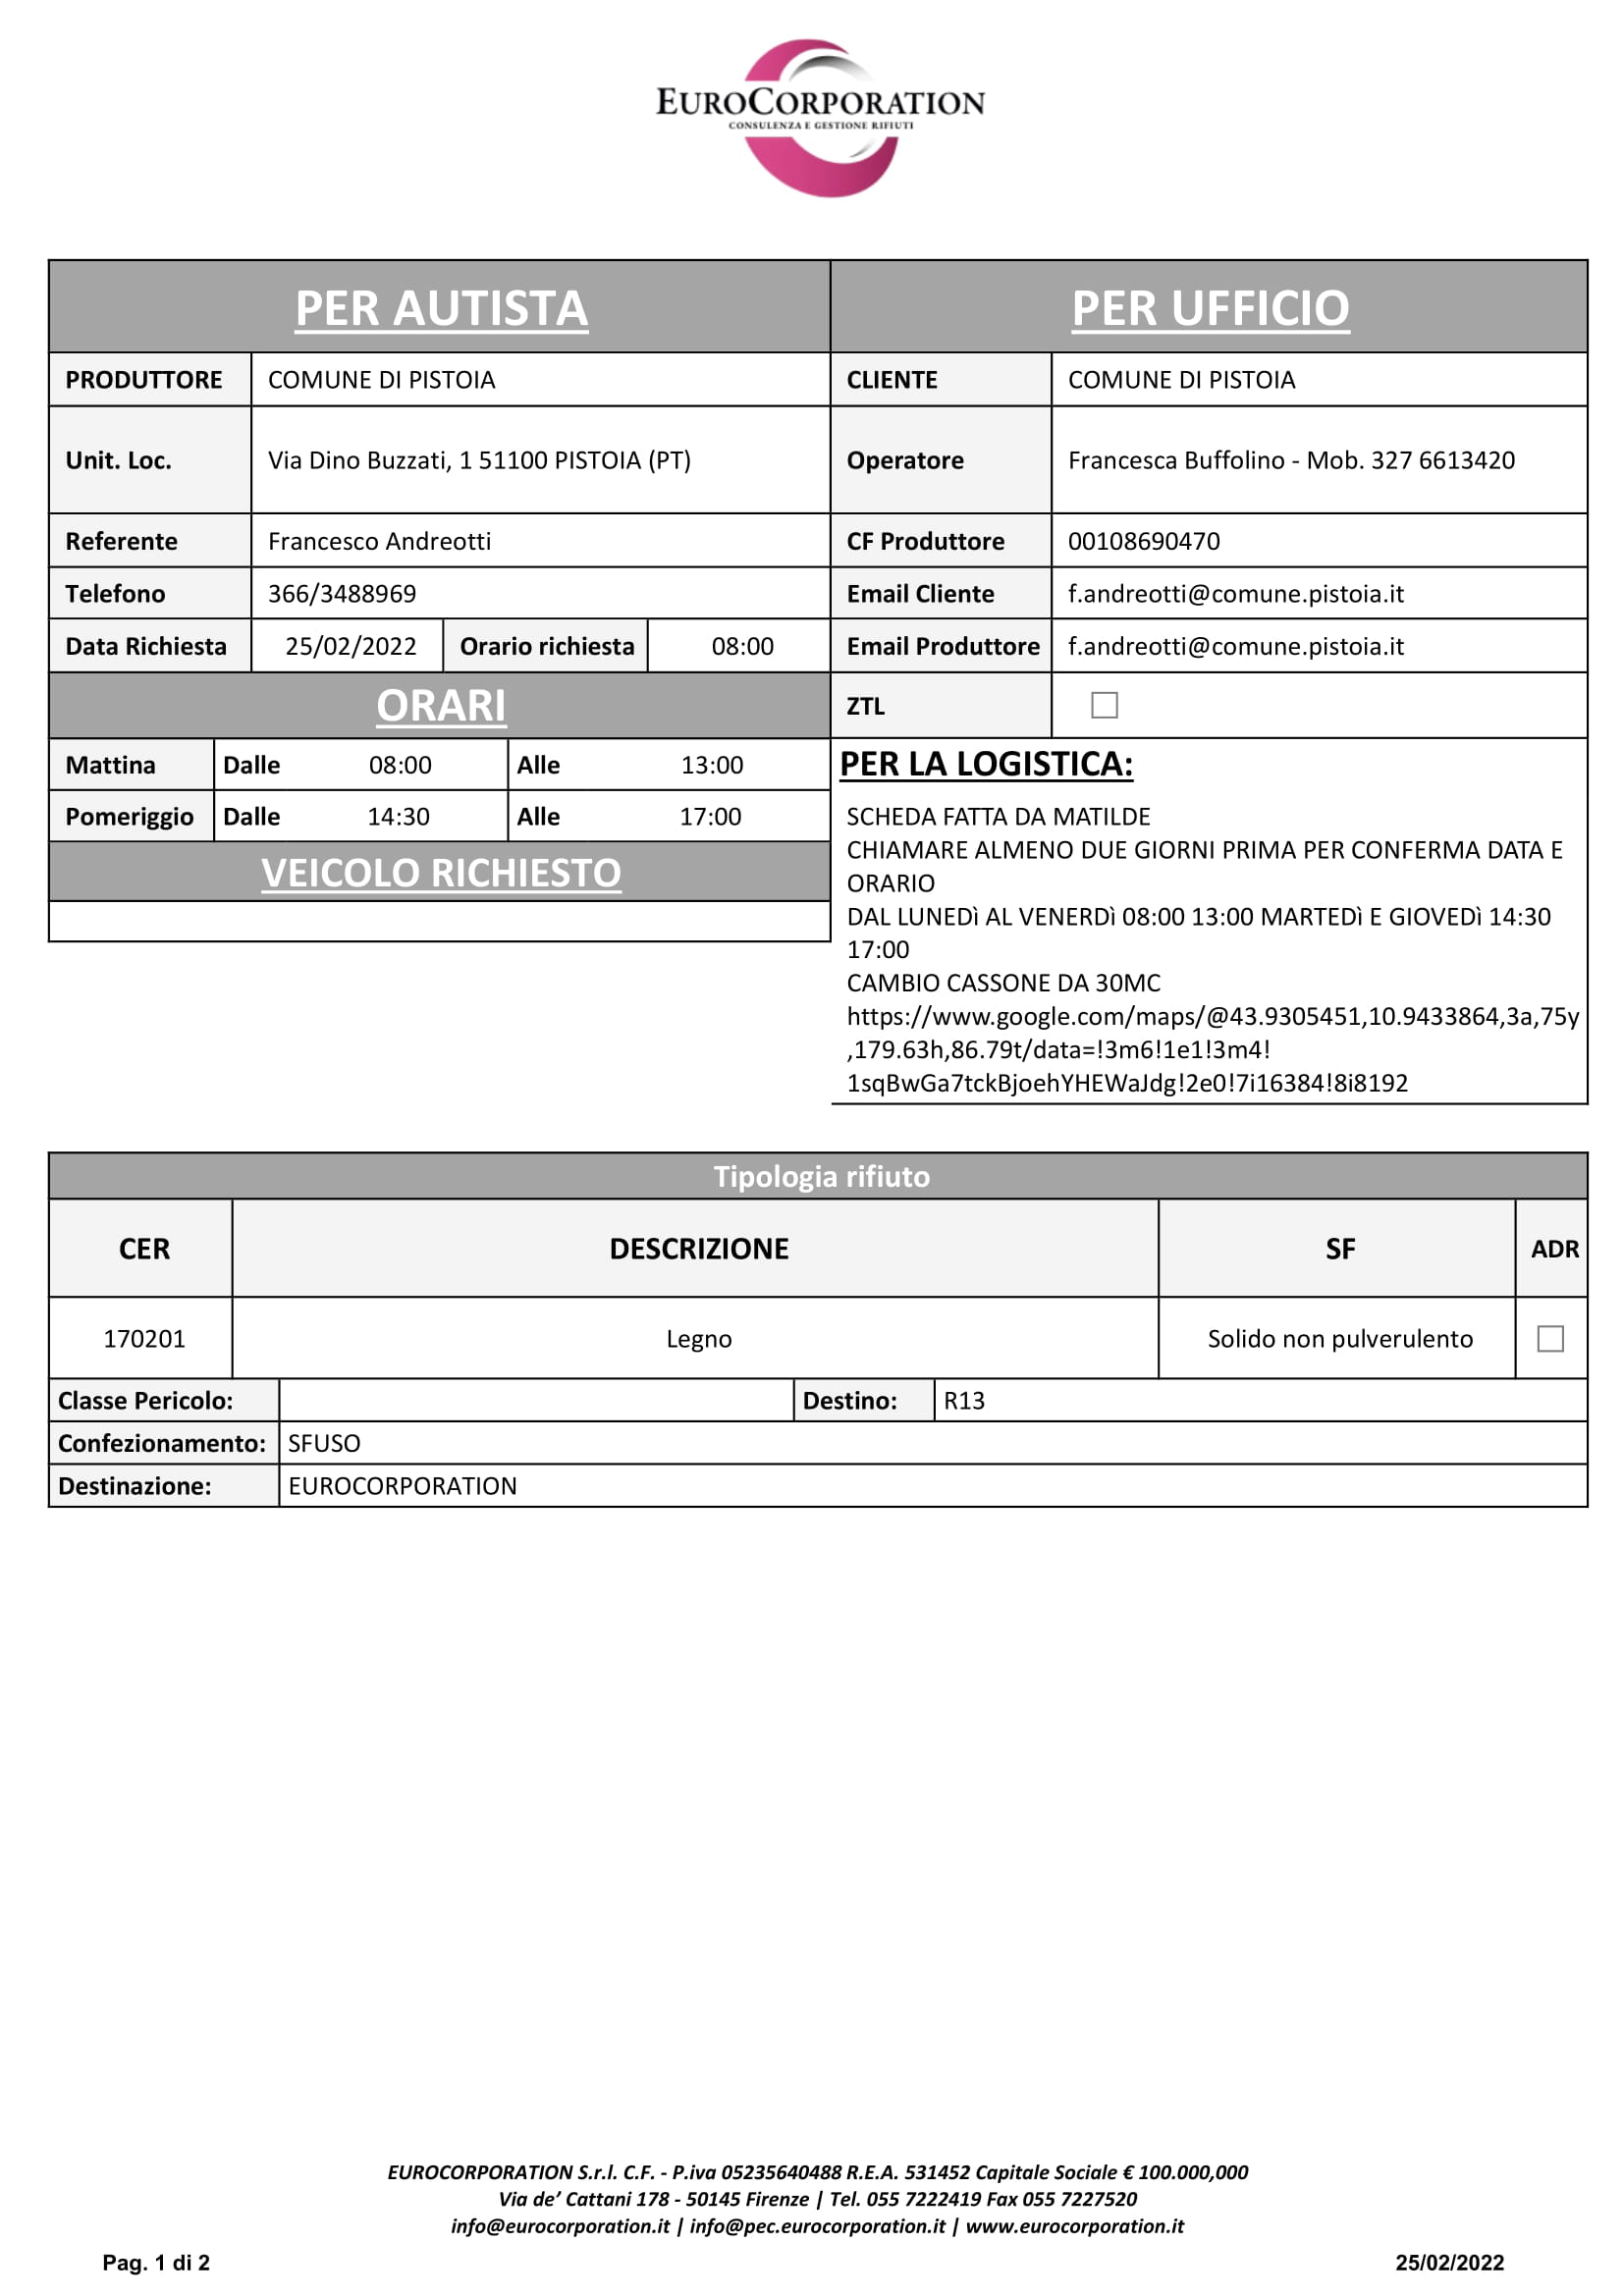

In [47]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open('/content/drive/MyDrive/EuroCoorp/CORDTest/layoutLMV2 -CORD/images/test/10.jpg')
image = image.convert("RGB")
image

In [48]:
test_dataset[0]

{'input_ids': tensor([  101,  1004,  1523,  1066,  9944, 24586, 21223, 11801,  2368,  4143,
         1041, 16216, 16643,  5643, 15544, 10258,  4904,  2140,  2566,  8740,
        16774,  2050,  2566,  1057, 26989,  9793,  4013,  8566,  9284,  2890,
        21130,  4487, 14255, 16033,  2401,  3131,  4135,  2278,  1012,  3081,
        22412, 12610, 10450,  1010,  1015,  4868, 18613, 14255, 16033,  2401,
         1006, 13866,  1007,  6523, 15781, 11400,  7213, 21325, 10093, 12879,
        17175,  4029,  2575,  1013,  4090,  2620,  2620,  2683,  2575,  2683,
         2951, 14411,  9153,  2423,  1013,  6185,  1013, 16798,  2475,  2030,
        16843, 14411,  9153,  2030, 16843, 14411,  9153,  5511,  1024,  4002,
         7396,  2063, 10125, 11266,  5498,  2139, 21815,  2717, 21159,  2072,
        27084,  1012, 21859,  1012,  6872,  2063, 21521, 12297, 27085,  1011,
        11240,  1012, 27908, 23833, 25746, 23499,  2692, 12935,  4013,  8566,
         9284,  2890,  5890,  2620, 18827, 22394, 

In [49]:
encoding = test_dataset[0]
processor.tokenizer.decode(encoding['input_ids'])

'[CLS] & “ ~ eurocorporation consulenza e gestione riflutl per autista per ufficio produttore comune di pistoia unitloc. via dino buzzati, 1 51100 pistoia ( pt ) referente francesco andreotti telefono 366 / 3488969 data richiesta 25 / 02 / 2022 orario richiesta orario richiesta 08 : 00 cliente montecatini dekor restauri soc. coop. operatore natalia veracini - mob. 3382652390 cf produttore 01824330474 email cliente montecatinicooperativa @ gmail. com email produttore montecatinicooperativa @ gmail. com orari mattina dalle 08 : 30 alle 12 : 30 pomeriggio dalle 14 : 30 alle 17 : 00 veicolo richiesto tipologia rifiuto cer 170201 per la logistica scheda fatta da matilde chiamare almeno due giorni prima per conferma data e orario dal lunedi al venerdi 08 : 00 13 : 00 martedi e giovedi 14 : 30 17 : 00 cambio cassone da 30mchttps : / / www. google. com / maps / @ 43. 9305451, 10. 9433864, 3a, 75y, 179. 63h, 86. 79t / data =! 3m6! 1e1! 3m4! 1sqbwga7tckbjoehyhewajdg! 2e0! 7i16384! 8i8192 170802 

In [50]:
ground_truth_labels = [id2label[label] for label in encoding['labels'].squeeze().tolist() if label != -100]
print(ground_truth_labels)

['header', 'other', 'other', 'question', 'answer', 'question', 'answer', 'question', 'answer', 'question', 'answer', 'question', 'answer', 'question', 'question', 'answer', 'question', 'answer', 'question', 'answer', 'question', 'answer', 'question', 'answer', 'question', 'answer', 'other', 'question', 'answer', 'question', 'answer', 'other', 'other', 'question', 'answer', 'question', 'answer', 'answer', 'header', 'other', 'other']


In [51]:
input_ids = encoding["input_ids"]
attention_mask = encoding["attention_mask"]
token_type_ids = encoding["token_type_ids"]
bbox = encoding["bbox"]
image=encoding['image']

In [52]:
# encoded_inputs =processor(input_ids,attention_mask,token_type_ids,bbox,image,return_tensors="pt")

In [53]:
for k,v in encoding.items():
  encoding[k] = v.unsqueeze(0).to(device)

model.eval()
# with torch.no_grad():
# outputs = model(**encoded_inputs)
# forward pass
outputs = model(input_ids=encoding['input_ids'], attention_mask=encoding['attention_mask'],
                token_type_ids=encoding['token_type_ids'], bbox=encoding['bbox'],
                image=encoding['image'])

In [54]:
# def unnormalize_box(bbox, width, height):
#      return [
#          width * (bbox[0] / 1000),
#          height * (bbox[1] / 1000),
#          width * (bbox[2] / 1000),
#          height * (bbox[3] / 1000),
#      ]

# predictions = outputs.logits.argmax(-1).squeeze().tolist()
# token_boxes = encoding.bbox.squeeze().tolist()

# width, height = image.size

# true_predictions = [id2label[prediction] for prediction, label in zip(predictions, labels) if label != -100]
# true_labels = [id2label[label] for prediction, label in zip(predictions, labels) if label != -100]
# true_boxes = [unnormalize_box(box, width, height) for box, label in zip(token_boxes, labels) if label != -100]

In [55]:
prediction_indices = outputs.logits.argmax(-1).squeeze().tolist()
print(prediction_indices)

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 3, 3, 3, 3, 3, 3, 0, 0, 3, 3, 0, 0, 3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

In [56]:
prediction_indices = outputs.logits.argmax(-1).squeeze().tolist()
predictions = [id2label[label] for gt, label in zip(encoding['labels'].squeeze().tolist(), prediction_indices) if gt != -100]
print(predictions)

['answer', 'question', 'question', 'question', 'answer', 'question', 'answer', 'question', 'answer', 'question', 'answer', 'question', 'answer', 'question', 'question', 'answer', 'question', 'answer', 'question', 'answer', 'question', 'answer', 'question', 'answer', 'question', 'answer', 'question', 'question', 'answer', 'question', 'answer', 'question', 'question', 'question', 'answer', 'question', 'answer', 'answer', 'answer', 'answer', 'answer']


In [57]:
import numpy as np

preds_val = None
out_label_ids = None

# put model in evaluation mode
model.eval()
for batch in tqdm(test_dataloader, desc="Evaluating"):
    with torch.no_grad():
        input_ids = batch['input_ids'].to(device)
        bbox = batch['bbox'].to(device)
        image = batch['image'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)

        # forward pass
        outputs = model(input_ids=input_ids, bbox=bbox, image=image, attention_mask=attention_mask, 
                        token_type_ids=token_type_ids, labels=labels)
        
        if preds_val is None:
          preds_val = outputs.logits.detach().cpu().numpy()
          out_label_ids = batch["labels"].detach().cpu().numpy()
        else:
          preds_val = np.append(preds_val, outputs.logits.detach().cpu().numpy(), axis=0)
          out_label_ids = np.append(out_label_ids, batch["labels"].detach().cpu().numpy(), axis=0)

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

In [58]:
import warnings
warnings.filterwarnings("ignore")
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score)

def results_test(preds, out_label_ids, labels):
  preds = np.argmax(preds, axis=2)

  label_map = {i: label for i, label in enumerate(labels)}

  out_label_list = [[] for _ in range(out_label_ids.shape[0])]
  preds_list = [[] for _ in range(out_label_ids.shape[0])]

  for i in range(out_label_ids.shape[0]):
      for j in range(out_label_ids.shape[1]):
          if out_label_ids[i, j] != -100:
              out_label_list[i].append(label_map[out_label_ids[i][j]])
              preds_list[i].append(label_map[preds[i][j]])

  results = {
      "precision": precision_score(out_label_list, preds_list),
      "recall": recall_score(out_label_list, preds_list),
      "f1": f1_score(out_label_list, preds_list),
  }
  return results, classification_report(out_label_list, preds_list)

In [59]:
labels = list(set(all_labels))
val_result, class_report = results_test(preds_val, out_label_ids, labels)
print("Overall results:", val_result)
print(class_report)

Overall results: {'precision': 0.8387096774193549, 'recall': 0.7222222222222222, 'f1': 0.7761194029850746}
              precision    recall  f1-score   support

       eader       0.00      0.00      0.00         2
       nswer       0.88      0.93      0.90        15
        ther       0.00      0.00      0.00         4
     uestion       0.80      0.80      0.80        15

   micro avg       0.84      0.72      0.78        36
   macro avg       0.42      0.43      0.43        36
weighted avg       0.70      0.72      0.71        36



## Inference

In [60]:
import pandas as pd
import numpy as np
import pytesseract
import torch
from itertools import groupby
from datasets import load_dataset 
from PIL import Image, ImageDraw, ImageFont
from transformers import LayoutLMv2FeatureExtractor, LayoutLMv2TokenizerFast
from transformers import LayoutLMv2ForTokenClassification

In [66]:
import gradio as gr
import numpy as np
from transformers import LayoutLMv2Processor, LayoutLMv2ForTokenClassification,LayoutLMv2FeatureExtractor
from PIL import Image, ImageDraw, ImageFont
import PIL

processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased")
model = LayoutLMv2ForTokenClassification.from_pretrained("/content/drive/MyDrive/EuroCoorp/CORDTest/layoutLMV2 -CORD/model/")

# define id2label
id2label = model.config.id2label
print('id2label',id2label)

label_ints = np.random.randint(0,len(PIL.ImageColor.colormap.items()),30)
print('id2label.items()',id2label.items())
label_color_pil = [k for k,_ in PIL.ImageColor.colormap.items()]
label_color = [label_color_pil[i] for i in label_ints]
label2color = {}
for k,v in id2label.items():
  if v[:2] == '':
    label2color['o']=label_color[k]
  else:
    label2color[v[2:]]=label_color[k]

# def load_image(path):
  
#   image = Image.open(path)
#   image = image.convert("RGB")
  
#   return image

def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]
def iob_to_label(label):
    label = label[:]
    if not label:
        return 'o'
    return label

def process_image(image):
    width, height = image.size
    print('width',width)
    print('height',height)

    feature_extractor = LayoutLMv2FeatureExtractor.from_pretrained("microsoft/layoutlmv2-base-uncased")
    encoding_feature_extractor = feature_extractor(image, return_tensors="pt")
    words, boxes = encoding_feature_extractor.words, encoding_feature_extractor.boxes


    # encode
    encoding = processor(image, return_offsets_mapping=True, return_tensors="pt")
    offset_mapping = encoding.pop('offset_mapping')

    # forward pass
    outputs = model(**encoding)

    # get predictions
    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    # print('predictions',predictions)
    token_boxes = encoding.bbox.squeeze().tolist()
    # print('token_boxes',token_boxes)

    # only keep non-subword predictions
    is_subword = np.array(offset_mapping.squeeze().tolist())[:,0] != 0
    true_predictions = [id2label[pred] for idx, pred in enumerate(predictions) if not is_subword[idx]]
    true_boxes = [unnormalize_box(box, width, height) for idx, box in enumerate(token_boxes) if not is_subword[idx]]
    
    true_boxes = true_boxes[1:-1]
    true_predictions = true_predictions[1:-1]


    preds = []
    l_words = []
    bboxes = []

    for i,j in enumerate(true_predictions):

      if j != 'O':
        preds.append(true_predictions[i])
        l_words.append(words[0][i])
        bboxes.append(true_boxes[i])

    return bboxes, preds, l_words, image

    # def iob_to_label(label):
    #   label = label[2:]
    #   if not label:
    #     return 'other'
    #   return label


def visualize_image(final_bbox, final_preds, l_words, image):

  draw = ImageDraw.Draw(image)
  font = ImageFont.load_default()
  

  #{'question': 0, 'header': 1, 'other': 2, 'answer': 3}
#{0: 'question', 1: 'header', 2: 'other', 3: 'answer'}
  #{'orariorichiesta': 0, 'produttore': 1, 'others': 2, 'unitloc': 3, 'cer': 4, 'datarichiesta': 5}
#{0: 'orariorichiesta', 1: 'produttore', 2: 'others', 3: 'unitloc', 4: 'cer', 5: 'datarichiesta'}
  #{0: 'LABEL_0', 1: 'LABEL_1', 2: 'LABEL_2', 3: 'LABEL_3', 4: 'LABEL_4', 5: 'LABEL_5'}

  label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}
  l2l = {'question':'key', 'answer':'value', 'header':'title'}
  f_labels = {'question':'key', 'answer':'value', 'header':'title', 'other':'others'}

  json_df = []

  for ix, (prediction, box) in enumerate(zip(final_preds, final_bbox)):
    predicted_label = iob_to_label(prediction).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=f_labels[predicted_label], fill=label2color[predicted_label], font=font)

    json_dict = {}
    json_dict['TEXT'] = l_words[ix]
    json_dict['LABEL'] = f_labels[predicted_label]
    
    json_df.append(json_dict)

  return image, json_df

def process_form(json_df):

  labels = [x['LABEL'] for x in json_df]
  texts = [x['TEXT'] for x in json_df]
  cmb_list = []
  for i, j in enumerate(labels):
    cmb_list.append([labels[i], texts[i]])

  grouper = lambda l: [[k] + sum((v[1::] for v in vs), []) for k, vs in groupby(l, lambda x: x[0])]

  list_final = grouper(cmb_list)
  lst_final = []
  for x in list_final:
    json_dict = {}
    json_dict[x[0]] = (' ').join(x[1:])
    lst_final.append(json_dict)

  return lst_final

from PIL import Image, ImageDraw, ImageFont
image = Image.open('/content/drive/Shareddrives/Data Science Team folder-open/Jyoti/layoutLMV2 -CORD/11.png')
image = image.convert("RGB")
# process_image(image)

# gets the bounding boxes, predictions, extracted words and image processed
bbox, preds, words, image = process_image(image)

# returns image and extracted key-value pairs along with title as the output
im, df = visualize_image(bbox, preds, words, image)

# process and returns k-v pairs by concatenating relevant strings.
df_main = process_form(df)

id2label {0: 'question', 1: 'header', 2: 'other', 3: 'answer'}
id2label.items() dict_items([(0, 'question'), (1, 'header'), (2, 'other'), (3, 'answer')])
width 1653
height 2339


In [67]:
df_main

[{'value': '&“~ EUROCORPORATION'},
 {'key': 'CONSULENZA'},
 {'value': 'E'},
 {'key': 'GESTIONE'},
 {'value': 'RIFLUTL'},
 {'key': 'PER UFFICIO COMUNE'},
 {'value': 'DI PISTOIA'},
 {'key': 'PRODUTTORE COMUNE'},
 {'value': 'DI PISTOIA'},
 {'key': 'CLIENTE'},
 {'value': 'Via Dino Buzzati, 1 51100 PISTOIA (PT)'},
 {'key': 'Operatore'},
 {'value': 'Francesca Buffolino - Mob. 327 6613420'},
 {'key': 'Unit.'},
 {'value': 'Loc.'},
 {'key': 'Referente'},
 {'value': 'Francesco Andreotti'},
 {'key': 'CF Produttore'},
 {'value': '00108690470'},
 {'key': 'Telefono Email Cliente'},
 {'value': '366/3488969 f.andreotti@comune.pistoia.it'},
 {'key': 'Data Richiesta'},
 {'value': '25/02/2022 |'},
 {'key': 'Orario richiesta Email Produttore'},
 {'value': '| f.andreotti@comune.pistoia.it'},
 {'key': 'Mattina'},
 {'value': 'Dalle 08:00'},
 {'key': 'PER'},
 {'value': 'LA'},
 {'key': 'LOGISTICA: Alle'},
 {'value': '17:00'},
 {'key': 'SCHEDA FATTA'},
 {'value': 'DA MATILDE'},
 {'key': 'Pomeriggio'},
 {'value'

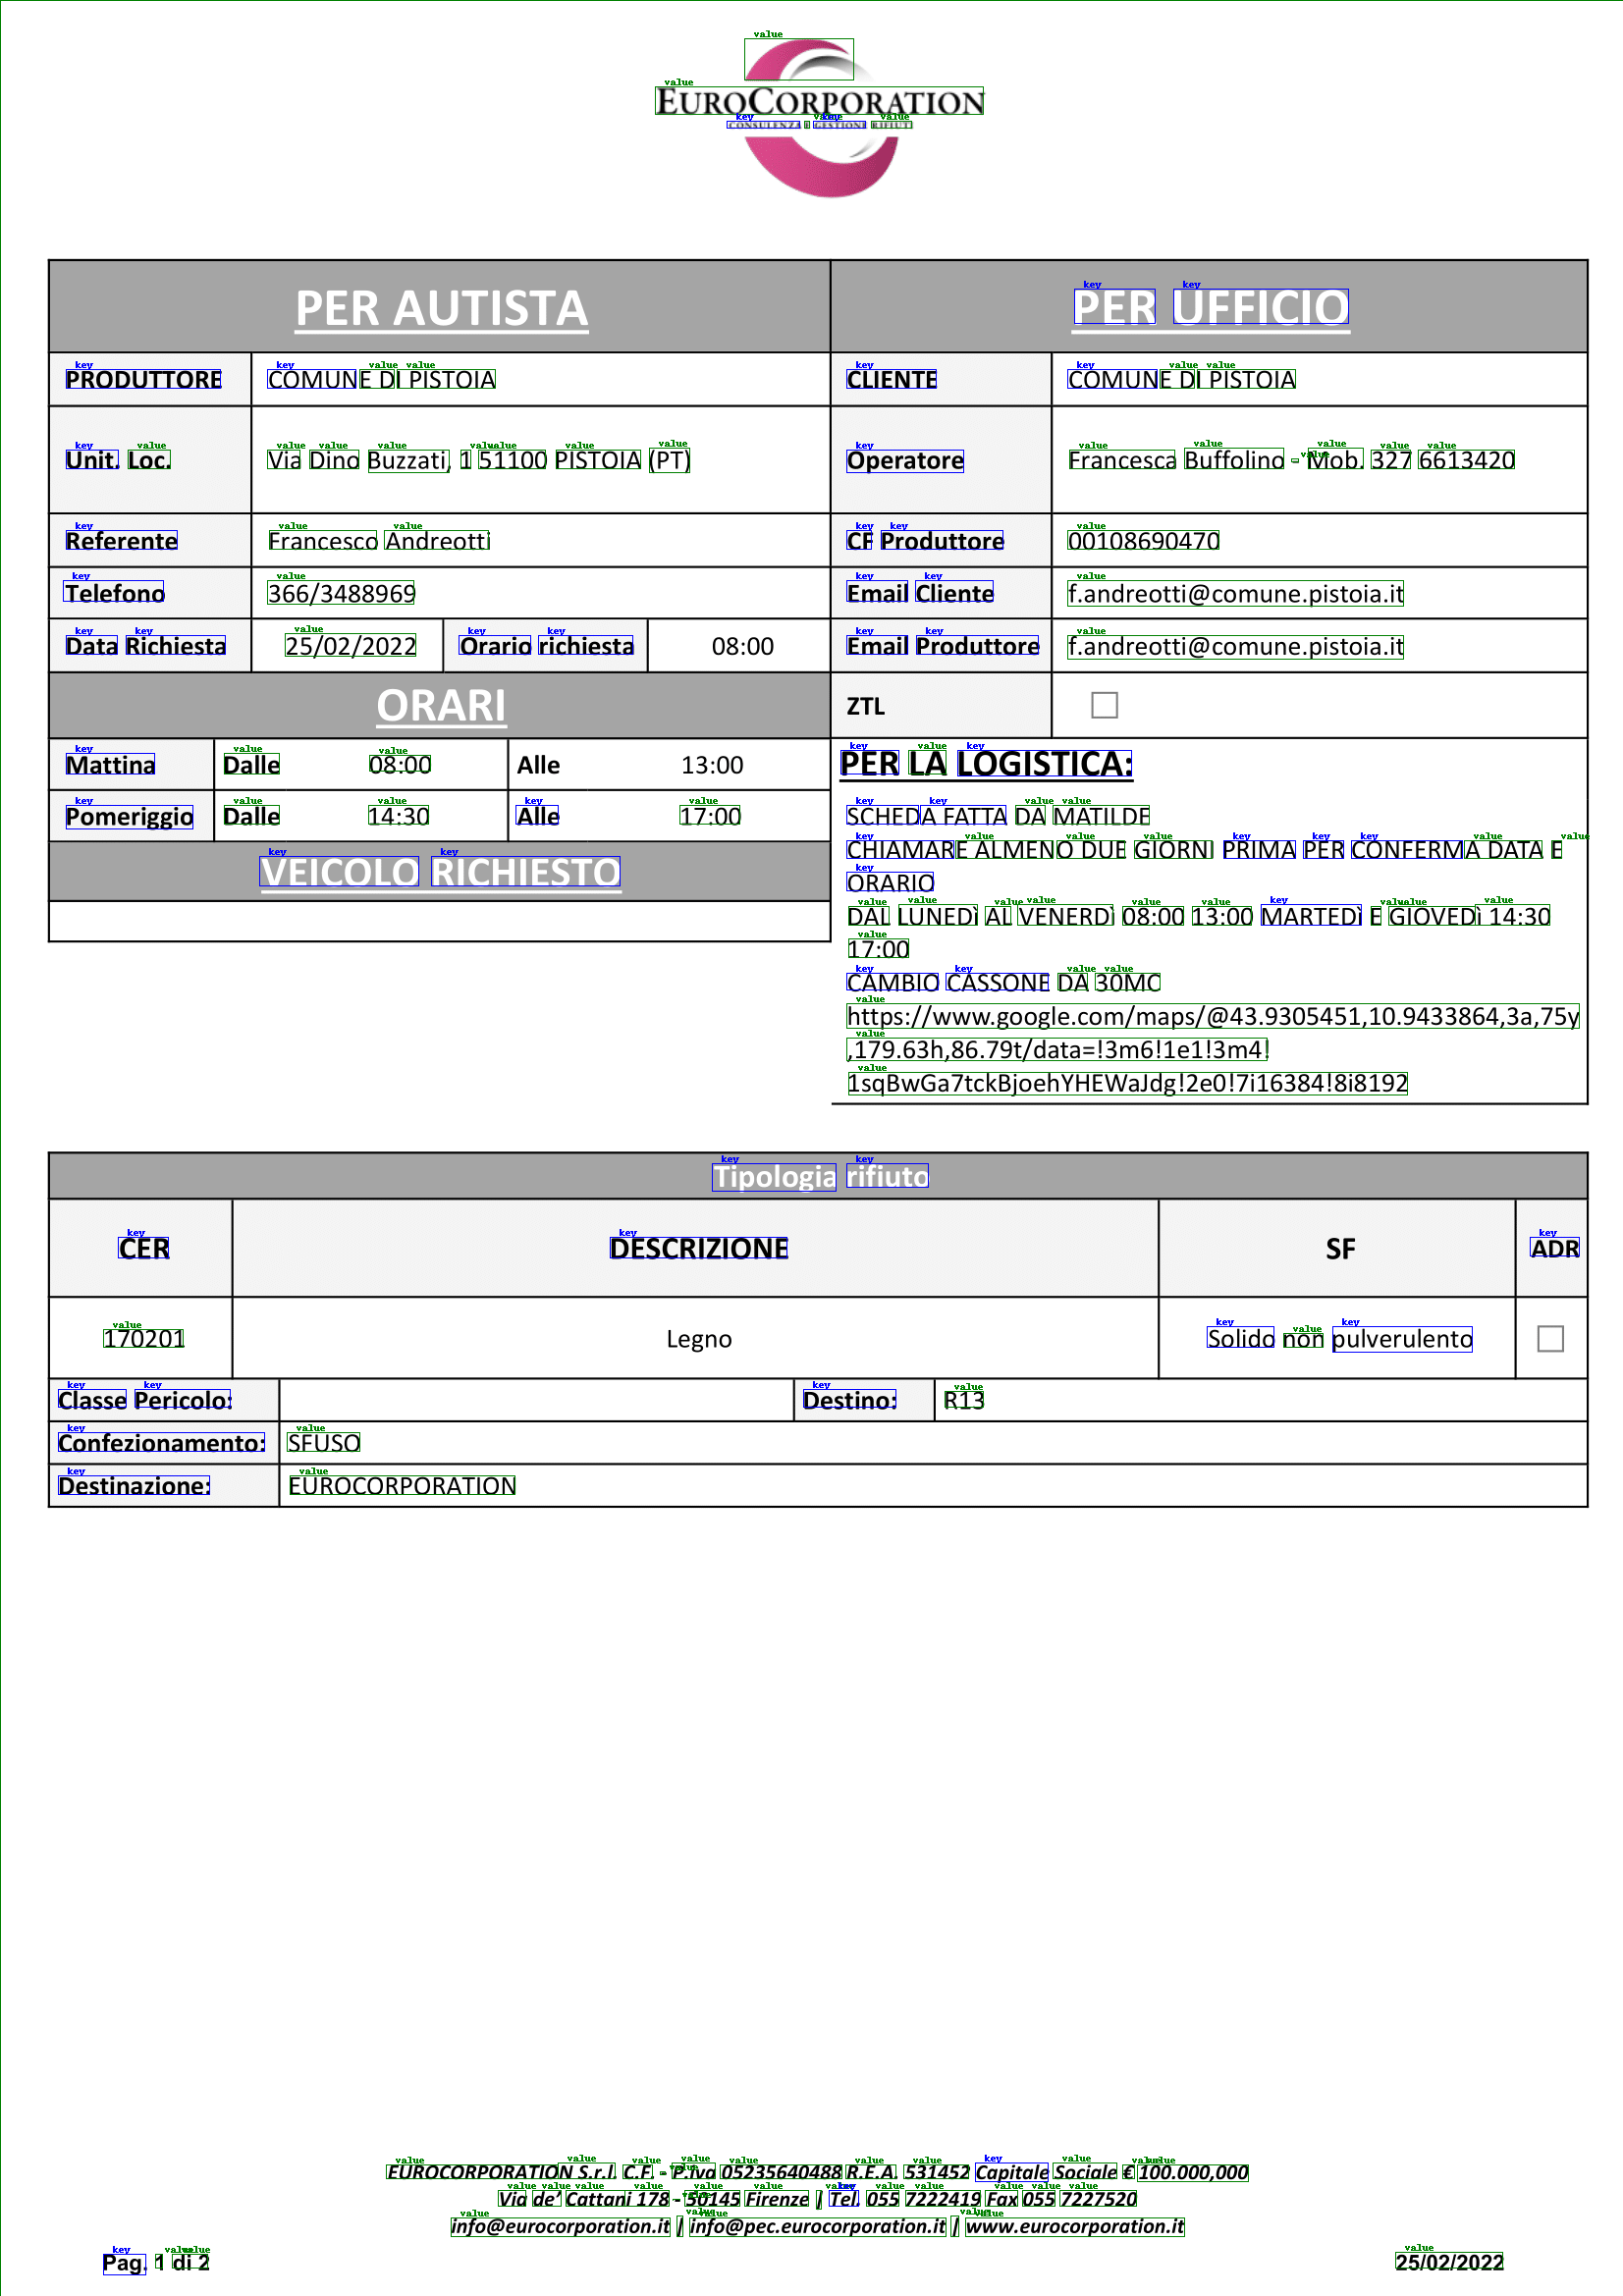

In [68]:
im

## Ground truth

In [69]:
# # Compare this to the ground truth
# from PIL import Image, ImageDraw, ImageFont

# image = Image.open('/content/images/1.png')
# image = image.convert("RGB")
# width, height = image.size
# draw = ImageDraw.Draw(image)

# for word, box, label in zip(example['words'], example['bboxes'], example['ner_tags']):
#   actual_label = iob_to_label(id2label[label]).lower()
#   box = unnormalize_box(box, width, height)
#   draw.rectangle(box, outline=label2color[actual_label], width=2)
#   draw.text((box[0] + 10, box[1] - 10), actual_label, fill=label2color[actual_label], font=font)

# image